<a href="https://colab.research.google.com/github/Deep-Poets-Society/Deep-Comedy/blob/main/generation_beam_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Colab Setup

import sys
import os

%cd /content
!rm -rf Deep-Comedy &> /dev/null
!git clone https://github.com/Deep-Poets-Society/Deep-Comedy &> /dev/null
%cd Deep-Comedy

sys.path.append(os.getcwd())

!pip install tensorflow &> /dev/null
!pip install tensorflow_text &> /dev/null

/content
/content/Deep-Comedy


In [2]:
from tokenizer import Tokenizer
import tensorflow as tf
import time
import numpy as np
import re
from matplotlib import pyplot as plt
from utils import load_dataset_for_gen, positional_encoding, loss_function, accuracy_function, plot_accuracy
from models import Transformer, create_masks
from schedules import CustomSchedule
from preprocessing import CESURA, SPACE, SYL, NEW_LINE

In [3]:
dataset = load_dataset_for_gen()
train = dataset['train']
val = dataset['val']

In [4]:
tokenizer = Tokenizer(['[START]', '[END]', f'{SPACE}', f'{NEW_LINE}'], 'res/vocab_gen.txt')

In [5]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [6]:
def tokenize_pairs(X, y):
    X = tokenizer.tokenize(X)
    # Convert from ragged to dense, padding with zeros.
    X = X.to_tensor()

    y = tokenizer.tokenize(y)
    # Convert from ragged to dense, padding with zeros.
    y = y.to_tensor()

    return X, y


def make_batches(ds):
    return (ds
            .cache()
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
            )

In [7]:
train_batches = make_batches(train)
val_batches = make_batches(val)

Hyperparameters

In [8]:
num_layers = 6
d_model = 512
dff = 2048
num_heads = 8
dropout_rate = 0.1

Set Adam Optimizer

In [9]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Loss and metrics

In [10]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')

Training and checkpoint


In [11]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizer.get_vocab_size().numpy(),
    target_vocab_size=tokenizer.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [12]:
checkpoint_path = "./checkpoints-gen/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [13]:
EPOCHS = 10

In [14]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [15]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [16]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # inp -> X, tar -> y
  for (batch, entry) in enumerate(train_batches):
    inp = entry[0]
    tar = entry[1]
    train_step(inp, tar)

    #if batch % 50 == 0:
    #  print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
  
  for val_entry in val_batches:
    val_inp = val_entry[0]
    val_tar = val_entry[1]
    val_tar_inp = val_tar[:, :-1]
    val_tar_real = val_tar[:, 1:]
    with tf.GradientTape() as tape:
      predictions, _ = transformer([val_inp, val_tar_inp],
                                 training = False)
    loss = loss_function(val_tar_real, predictions)
    val_loss(loss)
    val_accuracy(accuracy_function(val_tar_real, predictions))
  
  print(f'Epoch {epoch + 1} Train loss {train_loss.result():.4f} Train accuracy {train_accuracy.result():.4f}')
  print(f'Epoch {epoch + 1} Validation loss {val_loss.result():.4f} Validation accuracy {val_accuracy.result():.4f}')

  train_losses.append(train_loss.result().numpy())
  train_accuracies.append(train_accuracy.result().numpy())
  val_losses.append(val_loss.result().numpy())
  val_accuracies.append(val_accuracy.result().numpy())

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Train loss 4.0709 Train accuracy 0.2322
Epoch 1 Validation loss 3.5822 Validation accuracy 0.2854
Time taken for 1 epoch: 52.23 secs

Epoch 2 Train loss 3.4432 Train accuracy 0.2952
Epoch 2 Validation loss 2.8900 Validation accuracy 0.3729
Time taken for 1 epoch: 33.61 secs

Epoch 3 Train loss 2.7101 Train accuracy 0.3872
Epoch 3 Validation loss 2.4324 Validation accuracy 0.4263
Time taken for 1 epoch: 33.68 secs

Epoch 4 Train loss 2.4561 Train accuracy 0.4178
Epoch 4 Validation loss 2.3163 Validation accuracy 0.4388
Time taken for 1 epoch: 33.65 secs

Saving checkpoint for epoch 5 at ./checkpoints-gen/train/ckpt-1
Epoch 5 Train loss 2.3430 Train accuracy 0.4356
Epoch 5 Validation loss 2.2434 Validation accuracy 0.4496
Time taken for 1 epoch: 35.31 secs

Epoch 6 Train loss 2.2749 Train accuracy 0.4486
Epoch 6 Validation loss 2.1909 Validation accuracy 0.4671
Time taken for 1 epoch: 33.70 secs

Epoch 7 Train loss 2.2189 Train accuracy 0.4593
Epoch 7 Validation loss 2.1477 Valid

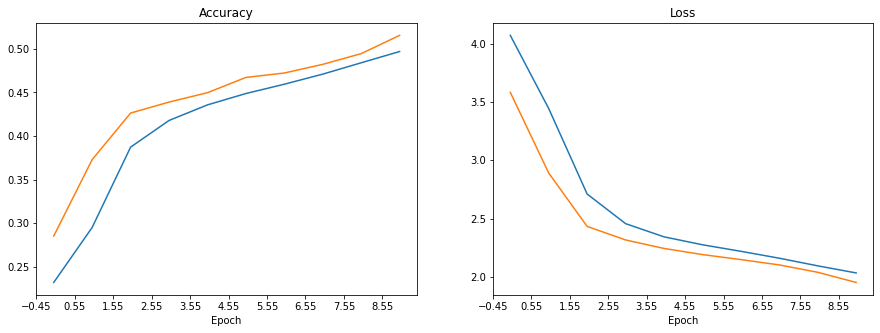

In [17]:
plot_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

Evaluate

In [75]:
def evaluate(line, max_length=100):
  line = tf.convert_to_tensor([line])
  line = tokenizer.tokenize(line).to_tensor()

  encoder_input = line

  start, end = tokenizer.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer.call((encoder_input, output),
                                                 False)

    # select the last word from the seq_len dimension
    # predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    # transpose the tensor to (seq_len, batch_size, vocab_size)
    predictions = tf.transpose(predictions, perm=[1,0,2])
    seq_len, batch_size, _ = predictions.shape

    decoded, _ = tf.nn.ctc_beam_search_decoder(
        predictions,
        tf.ones([batch_size], dtype=tf.int32)*seq_len,
        beam_width=1, top_paths=1
        )
    
    predicted_id = decoded[0].values[0]
    predicted_id_expanded = tf.expand_dims(predicted_id, 0)
    predicted_id_expanded = tf.expand_dims(predicted_id_expanded, 0)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id_expanded], axis=-1)
    print(predicted_id)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizer.detokenize(output)[0]  # shape: ()

  tokens = tokenizer.lookup(output)[0]

  return text, tokens, attention_weights

In [76]:
def print_prediction(x, true=None, add_spaces=True):
  if true is None:
    true = 'Not provided\n'

  if add_spaces:
    x = re.sub(' ', ' S ', x)
  
  predicted, _, _ = evaluate(x)
  predicted = predicted.numpy().decode('utf-8')
  x = re.sub(' S ', ' ', x)
  print(f'Original:\n{x}\n')
  print(f'Predicted:\n{predicted}\n')
  print(f'True:\n{true}\n')
  print('#'*20)

In [77]:
test = dataset['test']
for batch, (x, y) in enumerate(test.batch(1)):
  x = x.numpy()[0].decode('utf-8')
  y = y.numpy()[0].decode('utf-8')
  print_prediction(x, y, add_spaces=False)
  if batch >=9 :
    break

tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(6, shape=(),